# Fine-tuning a BERT model

**Acknowledgements:**
1. TensorFlow [Colab tutorial](https://www.tensorflow.org/official_models/fine_tuning_bert).  
2. [Github notebook](https://github.com/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb).  

**References:**
1.  
2.  

**Table of contents:**
1. [Setup](#Setup)  
   1. [tf-nightly](#tf-nightly)  
   2. [Imports](#Imports)  
   3. [Resources](#Resources)  
2. [Data](#Data)  


## Setup

### tf-nightly

Basic `conda` environment:
```
conda install -n tf-nightly python=3.7 cudatoolkit=10.1.243
conda install matplotlib jupyter notebook
```
`tf-nightly` installs `tensorflow-hub` and latest `tensorflow-datasets` among others, re-installs to the versions it needs, and installs the latest development verison of `tensorflow`. 
```
pip install tf-nightly
pip install tf-models-nightly
```
Updated tf to a dev version `2.4.0-dev20200702`. `official` seems to be part of `tf-nightly`.

### Imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [2]:
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

In [3]:
# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

/home/ivogeorg/anaconda3/envs/tf-nightly/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.4.0-dev20200702). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


### Resources

Configuration, vocabulary, and pre-trained checkpoint:

In [4]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)  # TODO: How does this work?

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

Pre-trained BERT encoder from TF Hub:

In [5]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

## Data

Data to be used is from [GLUE MRPC on TFDS](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc). The dataset is not set up to be directly fed into a BERT model, so some preprocessing is necessary.

### Get dataset from TFDS

MRPC [(Dolan & Brockett, 2005)](https://www.aclweb.org/anthology/I05-5002/) is a sentence-pair corpus automatically extracted from news sources, with human annotations for semantic equivalence (yes or no) of the sentences in each pair.
* Labels: 2  
* Training: 3668  
* Evaluation: 408  
* Max sequence length: 128  

In [6]:
# Dataset is small, so load the whole
glue, info = tfds.load('glue/mrpc', with_info=True, batch_size=-1)

/home/ivogeorg/anaconda3/envs/tf-nightly/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/ivogeorg/anaconda3/envs/tf-nightly/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/ivogeorg/anaconda3/envs/tf-nightly/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /home/ivogeorg/tensorflow_datasets/glue/mrpc/1.0.0.incompleteEDPQTD/glue-train.tfrecord


Shuffling and writing examples to /home/ivogeorg/tensorflow_datasets/glue/mrpc/1.0.0.incompleteEDPQTD/glue-validation.tfrecord


Shuffling and writing examples to /home/ivogeorg/tensorflow_datasets/glue/mrpc/1.0.0.incompleteEDPQTD/glue-test.tfrecord


Dataset glue downloaded and prepared to /home/ivogeorg/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.


In [7]:
list(glue.keys())

['test', 'train', 'validation']

The `info` object describes the dataset and its features:

In [8]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

The two classes are:

In [9]:
info.features['label'].names

['not_equivalent', 'equivalent']

Example from training set:

In [10]:
glue_train = glue['train']

for key, value in glue_train.items():
    print(f'{key:9s}: {value[0].numpy()}')

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


## BERT tokenizer

For fine-tuning a pre-trained model, exactly the same tokenization, vocabulary, and index mapping should be used as were used for training.

The BERT tokenizer is written in pure Python (that is, it is not built out of TF ops), so it cannot be plugged into the model as a `keras.layer` (like, for example, [`preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

The tokenizer has to be rebuilt:

In [11]:
# Set up tokenizer to generate TF dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, 'vocab.txt'),
    do_lower_case=True)

print('Vocab size: ', len(tokenizer.vocab))

Vocab size:  30522


Tokenize a sentence:

In [12]:
tokens = tokenizer.tokenize('Hello TensorFlow!')
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


## Data preprocessing

Manual preprocessing of the data into the format expected by the model. Since the MRPC dataset it small, this can be done easily in memory. (For larger datasets, the `tf_models` library has preprocessing and dataset re-serializing tools. Details a shown in the [Appendix](#Appendix).)

### Ragged tensors

TF2 [tutorial on ragged tensors](https://www.tensorflow.org/guide/ragged_tensor). From the overview:

*Ragged tensors* are the TensorFlow equivalent of *nested variable-length lists*. They make it easy to store and process data with *non-uniform shapes*, including:

* Variable-length features, such as the set of actors in a movie.  
* Batches of variable-length sequential inputs, such as sentences or video clips.  
* Hierarchical inputs, such as text documents that are subdivided into sections, paragraphs, sentences, and words.  
* Individual fields in structured inputs, such as protocol buffers.  

### Sentence encoding

The model expects the two sentences from the pair to *concatenated* together. The input should start with the *classification-problem token* `[CLS]` and end with the *separator token* `[SEP]`:

In [13]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Encode all the sentences, appending a `[SEP]` token and packing them into [*ragged tensors*](#Ragged-tensors):

In [14]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s.numpy()))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train['sentence1']
])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train['sentence2']
])

In [15]:
print('Sentence1 shape: ', sentence1.shape.as_list())
print('Sentence2 shape: ', sentence2.shape.as_list())

Sentence1 shape:  [3668, None]
Sentence2 shape:  [3668, None]


Prepend the `[CLS]` token and concatenate the ragged tensors to form a single `input_word_ids` tensor for each example. [`RaggedTensor.to_tensor()`](https://www.tensorflow.org/api_docs/python/tf/RaggedTensor#to_tensor) zero-pads to the longest sequence (in this case, 128, which is a parameter of the dataset).

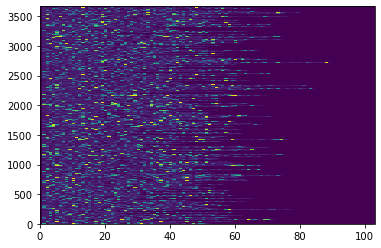

In [16]:
# TODO: Grok
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

### Mask and input type

The model expects two additional inputs:
* Input mask
  - Allows the model to cleanly differentiate between content and padding  
  - Has the same shape as `input_word_ids`  
  - Contains a `1` anywhere the `input_word_ids` is not padding  
* Input type  
  - Has the same shape as `input_word_ids`  
  - Inside the non-padded region, has 0 for sentence1 and 1 for sentence2  

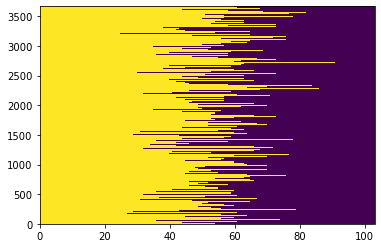

In [17]:
input_mask = tf.ones_like(input_word_ids).to_tensor()
plt.pcolormesh(input_mask)

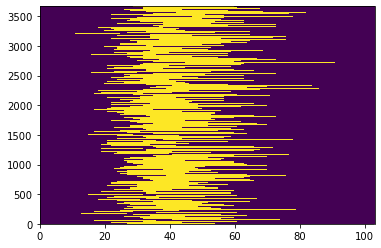

In [19]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()
plt.pcolormesh(input_type_ids)

### Putting it all together

Collect parsing code into a single function and apply to each split of the GLUE/MRPC dataset:

In [20]:
def encode_sentence(s, tokenizer):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
    num_examples = len(glue_dict['sentence1'])
    
    sentence1 = tf.ragged.constant([
        encode_sentence(s, tokenizer)
        for s in np.array(glue_dict['sentence1'])
    ])
    sentence2 = tf.ragged.constant([
        encode_sentence(s, tokenizer)
        for s in np.array(glue_dict['sentence2'])
    ])
    
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
    
    input_mask = tf.ones_like(input_word_ids).to_tensor()
    
    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()
    
    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }
    
    return inputs

In [21]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels = glue['test']['label']

Each subset of the data has been converted to a dictionary of features and a set of labels. Each feature in the input dictionary has the same shape and the number of labels should match:

In [22]:
for key, value in glue_train.items():
    print(f'{key:15s} shape: {value.shape}')
    
print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


In [23]:
for key, value in glue_validation.items():
    print(f'{key:15s} shape: {value.shape}')
    
print(f'glue_validation_labels shape: {glue_validation_labels.shape}')

input_word_ids  shape: (408, 86)
input_mask      shape: (408, 86)
input_type_ids  shape: (408, 86)
glue_validation_labels shape: (408,)


In [24]:
for key, value in glue_test.items():
    print(f'{key:15s} shape: {value.shape}')
    
print(f'glue_test_labels shape: {glue_test_labels.shape}')

input_word_ids  shape: (1725, 104)
input_mask      shape: (1725, 104)
input_type_ids  shape: (1725, 104)
glue_test_labels shape: (1725,)


## Model

### Build model

Download configuration of pre-trained model.

In [26]:
import json

bert_config_file = os.path.join(gs_folder_bert, 'bert_config.json')
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

The `config` defines the core BERT model, which is a Keras model to predict the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

The following function returns both the encoder and decoder:

In [27]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config,
    num_labels=2
)

The classifier has 3 inputs and 1 output:

In [28]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
